# Определение возраста покупателей

## Описание задачи

Создать модель для определения возраста покупателей по изображениям

## Исследовательский анализ данных

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

RANDOM_STATE = 12345

In [38]:
labels = pd.read_csv('./data/faces/labels.csv')
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [39]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


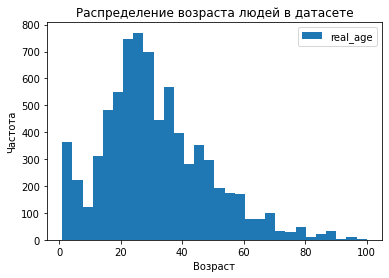

In [40]:
ax = labels.plot(kind='hist', bins=30, title='Распределение возраста людей в датасете');
ax.set_xlabel('Возраст');
ax.set_ylabel('Частота');

In [41]:
train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1/255
)

train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    x_col='file_name',
    y_col='real_age',
    directory='./data/faces/final_files',
    target_size=(150, 150),
    batch_size=32,
    class_mode='raw',
    seed=RANDOM_STATE)

features, target = next(train_datagen_flow)

Found 7591 validated image filenames.


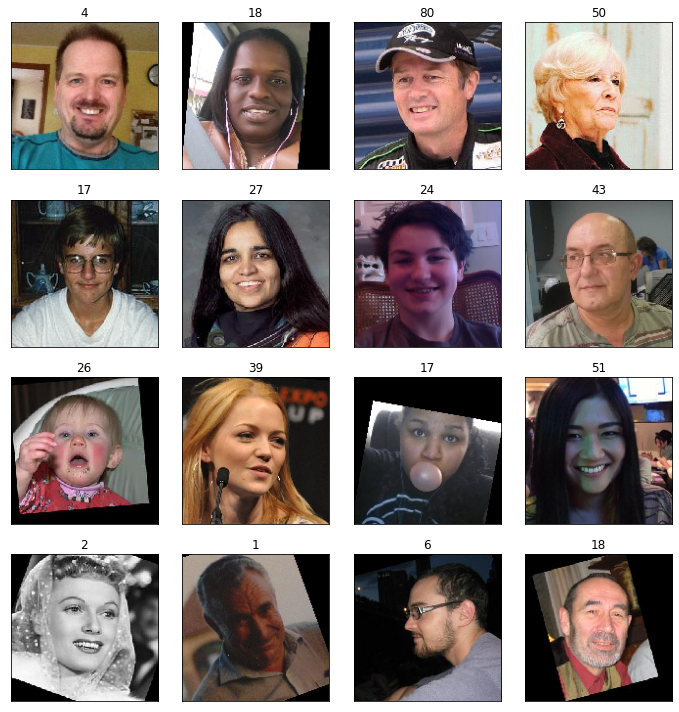

In [42]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод

- Количество изображений: 7591
- Средний возраст: 31 год
- Больше всего людей в районе 25 лет это может лучше всего обучить нейросеть определять этот возраст
- Меньше всего людей в районе 10 лет и старше 60 на них нейросеть обучится хуже всего
- Дастет размечен не совсем корректно, возраст на некоторых изображениях явно не соответствует реальному
- Люди представленаы разного пола и национальности в разном окружении и позе
- Есть обработанные изображения: сдвиги, повороты, чёрно-белые и цветные

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

RANDOM_STATE = 12345

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255,
        horizontal_flip=True,
        vertical_flip=False,
        rotation_range=45,
    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        x_col='file_name',
        y_col='real_age',
        directory=path+'final_files',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=RANDOM_STATE
    )

    return train_datagen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        x_col='file_name',
        y_col='real_age',
        directory=path+'final_files',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=RANDOM_STATE
    )

    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(learning_rate = 0.0001)
    
    backbone = ResNet50(
        input_shape=(200, 200, 3),
        weights='imagenet',
        include_top=False
    )
    
    model = Sequential()
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(units=1, activation='linear'))
    
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=6,
               steps_per_epoch=None, validation_steps=None):

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs, 
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True
    )

    return model
```

```bash
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
Using TensorFlow backend.

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps
Epoch 1/6
356/356 - 101s - loss: 11.5014 - mae: 11.5021 - val_loss: 13.9520 - val_mae: 13.9432
Epoch 2/6
356/356 - 98s - loss: 9.1185 - mae: 9.1188 - val_loss: 12.6836 - val_mae: 12.6792
Epoch 3/6
356/356 - 104s - loss: 8.5511 - mae: 8.5520 - val_loss: 7.9776 - val_mae: 7.9914
Epoch 4/6
356/356 - 105s - loss: 7.9822 - mae: 7.9819 - val_loss: 7.5026 - val_mae: 7.5016
Epoch 5/6
356/356 - 105s - loss: 7.5758 - mae: 7.5754 - val_loss: 8.5732 - val_mae: 8.5875
Epoch 6/6
356/356 - 105s - loss: 7.3421 - mae: 7.3423 - val_loss: 7.0782 - val_mae: 7.0818
119/119 - 11s - loss: 7.0782 - mae: 7.0818
Test MAE: 7.0818
```

## Анализ обученной модели

- Была обучена модель компьютерного зрения для определения возраста человека по фотографии
- Метрика на валидационной выборке **MAE 7** — средняя абсолютная ошибка в 7 лет
- Модель основана (backbone) на архитектуре `ResNet`
    - с предобученными весами на датасете `imagenet`
    - отключёнными выходными слоями
    - есть собственное дополнение полносвязного слоя из 256 нейронов и `Dropout(0.5)`
    - использована MAE функция потерь
- В предподготовку изображений вошли операции: горизонатльного отражения, поворотов в пределах 45 градусов и отключением вертикального отражения
- В целом если учитывать разброс определения возраста в 7 лет, бизнес сможет решить свои задачи
    - Задача "Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы" может быть выполнена полностью
    - Задача "Контролировать добросовестность кассиров при продаже алкоголя" может быть выполнена частично, нельзя точно предсказать возраст, следовательно будет выдаваться предупреждение с учётом разброса, например для проверки документов
    - Задачи могут быть выполнены лучше если подобрать более качественный датасет